# PTB-XL, a large publicly available electrocardiography dataset

Wagner, P., Strodthoff, N., Bousseljot, R., Samek, W., & Schaeffter, T. (2022). PTB-XL, a large publicly available electrocardiography dataset (version 1.0.3). PhysioNet. https://doi.org/10.13026/kfzx-aw45.

Important aspects of the datset:

- Dataset of 21799 clinical 12-lead ECGs from 18869 patients of 10 second length.
- There are 71 different ECG statements conform to the SCP-ECG standard that cover information about diagnostic, form, and rhythm.
- Splits into training and test sets are provided to ensure comparability of machine learning algorithms.
- The dataset is complemented by extensive metadata on demographics, infarction characteristics, likelihoods for diagnostic ECG statements as well as annotated signal properties.
- The waveform files are stored in WaveForm DataBase (WFDB) format with 16 bit precision at a resolution of 1μV/LSB and a sampling frequency of 500Hz. For the user’s convenience is released a downsampled versions of the waveform data at a sampling frequency of 100Hz.

For more information on this dataset see the [PhysioNet website](https://physionet.org/content/ptb-xl/1.0.3/)

## Required data

In this project we will use the following data from the PhysioNet PTB-XL repository:

- `records100`: Folder with the ECG signals downsampled at a sampling frequency of 100Hz.

- `ptbxl_database.csv`: Relevant metadata with one row per record identified by `ecg_id`. It contains 28 columns that can be categorized into:

    1. **Identifiers**: Each record is identified by a unique `ecg_id`. The corresponding patient is encoded via `patient_id`. The paths to the original record (500 Hz) and a downsampled version of the record (100 Hz) are stored in `filename_hr` and `filename_lr` respectively.
    2. **General Metadata**: demographic and recording metadata such as `age`, `sex`, `height`, `weight`, `nurse`, `site`, `device` and `recording_date`.
    3. **ECG statements**: core components are `scp_codes` (SCP-ECG statements as a dictionary with entries of the form statement: likelihood, where likelihood is set to 0 if unknown) and `report` (report string). Additional fields are `heart_axis`, `infarction_stadium1`, `infarction_stadium2`, `validated_by`, `second_opinion`, `initial_autogenerated_report` and `validated_by_human`.
    4. **Signal Metadata**: signal quality such as noise (`static_noise` and `burst_noise`), baseline drifts (`baseline_drift`) and other artifacts such as `electrodes_problems`. We also provide `extra_beats` for counting extra systoles and pacemaker for signal patterns indicating an active pacemaker.
    5. Cross-validation Folds: recommended 10-fold train-test splits (`strat_fold`) obtained via stratified sampling while respecting patient assignments, i.e. all records of a particular patient were assigned to the same fold. Records in fold 9 and 10 underwent at least one human evaluation and are therefore of a particularly high label quality. We therefore propose to use folds 1-8 as training set, fold 9 as validation set and fold 10 as test set.

- `scp_statements.csv`: All information related to the used annotation scheme that was enriched with mappings to other annotation standards such as AHA, aECGREFID, CDISC and DICOM. We provide additional side-information such as the category each statement can be assigned to (diagnostic, form and/or rhythm). For diagnostic statements, we also provide a proposed hierarchical organization into `diagnostic_class` and `diagnostic_subclass`.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ast
import numpy as np

import pandas as pd
import seaborn as sns
import wfdb

from ptbxl.utils.paths import data_raw_dir, data_interim_dir
from ptbxl.data.make_dataset import load_raw_data

sns.set_theme()

## Download the data

You can download the data directly from the [PhysioNet website](https://physionet.org/content/ptb-xl/1.0.3/). If this is the case, place the `ptbxl_database.csv` and `scp_statements.csv` inside the `data/raw` directory and the `records100` content in the `data/raw/physionet.org/files/ptb-xl/1.0.3`.

To download the contents via the ! shell command, first you need to have `wget` utility installed. On a Windows system you can download it from the [link](https://eternallybored.org/misc/wget/). Select the latest version according to your operating system. Then place the `wget.exe` file into the `C:\Windows\System32` folder and provide admin permisions.

To verify that `wget` has been installed correctly, open the Command Prompt or PowerShell and type the following command:

```bash
wget -V
```

In [3]:
# !wget -N -c -np https://physionet.org/files/ptb-xl/1.0.3/ptbxl_database.csv -P {str(data_raw_dir())}
# !wget -N -c -np https://physionet.org/files/ptb-xl/1.0.3/scp_statements.csv -P {str(data_raw_dir())}
# !wget -r -N -c -np https://physionet.org/files/ptb-xl/1.0.3/records100/ -P {str(data_raw_dir())}

## Metadata

In [4]:
# Load data
metadata = pd.read_csv(data_raw_dir("ptbxl_database.csv"), index_col="ecg_id")

# Evaluate str as a python dictionary
metadata["scp_codes"] = metadata["scp_codes"].apply(
    lambda x: ast.literal_eval(x),
)

print(f"Number of records: {len(metadata)}")
display(metadata.head())
display(metadata.describe())

# Return the key with the maximum likelihood value from the input dictionary
metadata["max_likelihood"] = metadata["scp_codes"].apply(
    lambda x: max(x, key=x.get)
)

print(f"Most recurrent statements:")
print(metadata["max_likelihood"].value_counts())

Number of records: 21799


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


,patient_id,age,sex,height,weight,nurse,site,validated_by,strat_fold
count,21799.000000,21799.000000,21799.000000,6974.000000,9421.000000,20326.000000,21782.000000,12421.000000,21799.000000
mean,11250.156521,62.769301,0.479150,166.702323,70.995223,2.291745,1.544945,0.746075,5.503005
std,6235.026404,32.308813,0.499577,10.867321,15.878803,3.254033,4.172883,1.178003,2.874948
min,302.000000,2.000000,0.000000,6.000000,5.000000,0.000000,0.000000,0.000000,1.000000
25%,5974.500000,50.000000,0.000000,160.000000,60.000000,0.000000,0.000000,0.000000,3.000000
50%,11419.000000,62.000000,0.000000,166.000000,70.000000,1.000000,1.000000,1.000000,6.000000
75%,16607.500000,72.000000,1.000000,174.000000,80.000000,3.000000,2.000000,1.000000,8.000000
max,21797.000000,300.000000,1.000000,209.000000,250.000000,11.000000,50.000000,11.000000,10.000000


Most recurrent statements:
max_likelihood
NORM       9134
IMI        1677
NDT        1613
ASMI       1457
LVH        1141
LAFB        888
IRBBB       831
CLBBB       527
NST_        502
CRBBB       385
ISC_        356
IVCD        334
ISCAL       333
ILMI        329
PACE        288
PVC         238
1AVB        201
AMI         173
INJAS       147
ALMI        134
ISCAS       118
ISCIN       104
ISCIL        89
LNGQT        80
WPW          74
LAO/LAE      73
LMI          63
AFLT         55
ISCLA        52
ILBBB        45
AFIB         45
IPLMI        43
INJAL        40
RAO/RAE      34
EL           31
IPMI         28
LPFB         23
PSVT         23
ISCAN        20
DIG          20
PMI          10
RVH           9
SEHYP         8
SR            5
3AVB          4
INJIL         3
STACH         3
INJLA         3
2AVB          3
INJIN         2
PAC           1
Name: count, dtype: int64


## Rhythm statements

Select the rhythm statements related to rhythm abnormalities as the target to place a classification problem. Additionaly we remove the patients with sinus rhythm (SR) and normal functioning artificial pacemaker (PACE) as these correspond to types of normal heart rhythms.

In [5]:
scp_DIR = data_raw_dir("scp_statements.csv")
scp_statements = pd.read_csv(scp_DIR, index_col=0)

# Get the statements related to rhythm problems
scp_rhythm_statements = scp_statements[
    (scp_statements["rhythm"] == 1)
    & (scp_statements.index != "PACE")
    & (scp_statements.index != "SR")
]
display(scp_rhythm_statements.head())
print("\n")
print(scp_rhythm_statements["Statement Category"].value_counts())
print("\n")
print(scp_rhythm_statements["description"])

,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
AFIB,atrial fibrillation,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,atrial fibrillation,50.0,MDC_ECG_RHY_ATR_FIB,NaN,D3-31520
STACH,sinus tachycardia,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,sinus tachycardia,21.0,MDC_ECG_RHY_SINUS_TACHY,NaN,NaN
SARRH,sinus arrhythmia,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,sinus arrhythmia,23.0,MDC_ECG_RHY_SINUS_ARRHY,NaN,NaN
SBRAD,sinus bradycardia,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,sinus bradycardia,22.0,MDC_ECG_RHY_SINUS_BRADY,NaN,NaN
SVARR,supraventricular arrhythmia,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,supraventricular arrhythmia,NaN,NaN,NaN,NaN




Statement Category
Statements related to impulse formation (abnormalities)    8
Statements related to ectopic rhythm abnormalities         2
Name: count, dtype: int64


AFIB                                   atrial fibrillation
STACH                                    sinus tachycardia
SARRH                                     sinus arrhythmia
SBRAD                                    sinus bradycardia
SVARR                          supraventricular arrhythmia
BIGU     bigeminal pattern (unknown origin, SV or Ventr...
AFLT                                        atrial flutter
SVTAC                         supraventricular tachycardia
PSVT               paroxysmal supraventricular tachycardia
TRIGU    trigeminal pattern (unknown origin, SV or Vent...
Name: description, dtype: object


## Build dataset

Form a dataset of records of patients with rhythm abnormalities and normal rhythm patients. Additionaly the patients classified as SR and PACE are included in the normal rhythm patients.

In [6]:
dataset_metadata = pd.concat([
    metadata[metadata["max_likelihood"].isin(scp_rhythm_statements.index)],
    metadata[metadata["max_likelihood"].isin(["NORM", "SR", "PACE"])]
]).reset_index()

dataset_metadata.loc[dataset_metadata["max_likelihood"].isin(
    ["NORM", "SR", "PACE"]), "target"] = 0
dataset_metadata.loc[~dataset_metadata["max_likelihood"].isin(
    ["NORM", "SR", "PACE"]), "target"] = 1

print(f"Number of records: {len(dataset_metadata)}")
display(dataset_metadata.head())

print(dataset_metadata["target"].value_counts())

Number of records: 9553


,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,max_likelihood,target
0,17,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-20 14:25:25,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00017_lr,records500/00000/00017_hr,AFLT,1.0
1,18,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-20 15:17:24,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00018_lr,records500/00000/00018_hr,AFLT,1.0
2,20,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-23 12:55:32,...,NaN,NaN,NaN,VES,NaN,9,records100/00000/00020_lr,records500/00000/00020_hr,AFLT,1.0
3,23,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-25 12:49:40,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00023_lr,records500/00000/00023_hr,AFLT,1.0
4,34,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-10 12:04:03,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00034_lr,records500/00000/00034_hr,AFLT,1.0


target
0.0    9427
1.0     126
Name: count, dtype: int64


### Save dataset metadata

In [7]:
dataset_metadata.to_csv(data_interim_dir("dataset_metadata.csv"), index=False)

## Load ECG signals

In [8]:
fs = 100  # Sampling rate (Hz)
ecgs = load_raw_data(
    dataset_metadata,
    sampling_rate=fs,
    path=data_raw_dir("physionet.org/files/ptb-xl/1.0.3"),
)
print(ecgs.shape)

(9553, 1000, 12)


### Plot normal sample

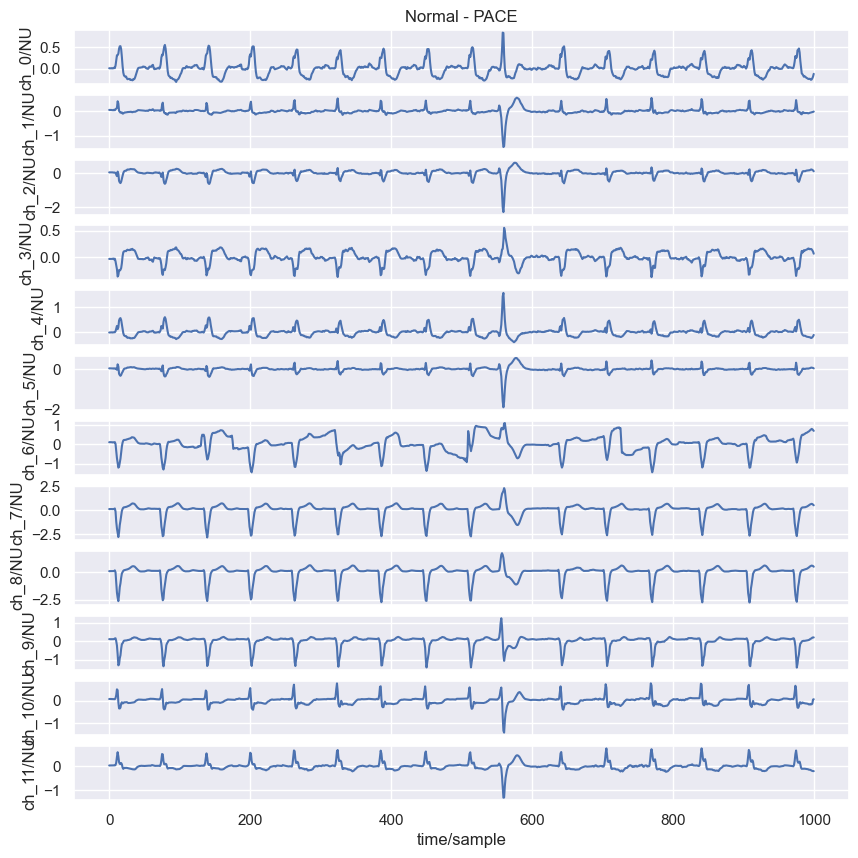

In [9]:
normal_sample = dataset_metadata[dataset_metadata["target"] == 0].sample(
    random_state=123)

wfdb.plot_items(
    np.squeeze(ecgs[normal_sample.index]),
    fs=fs,
    title="Normal" + " - " + normal_sample["max_likelihood"].item(),
    figsize=(10, 10),
)

### Plot abnormal sample

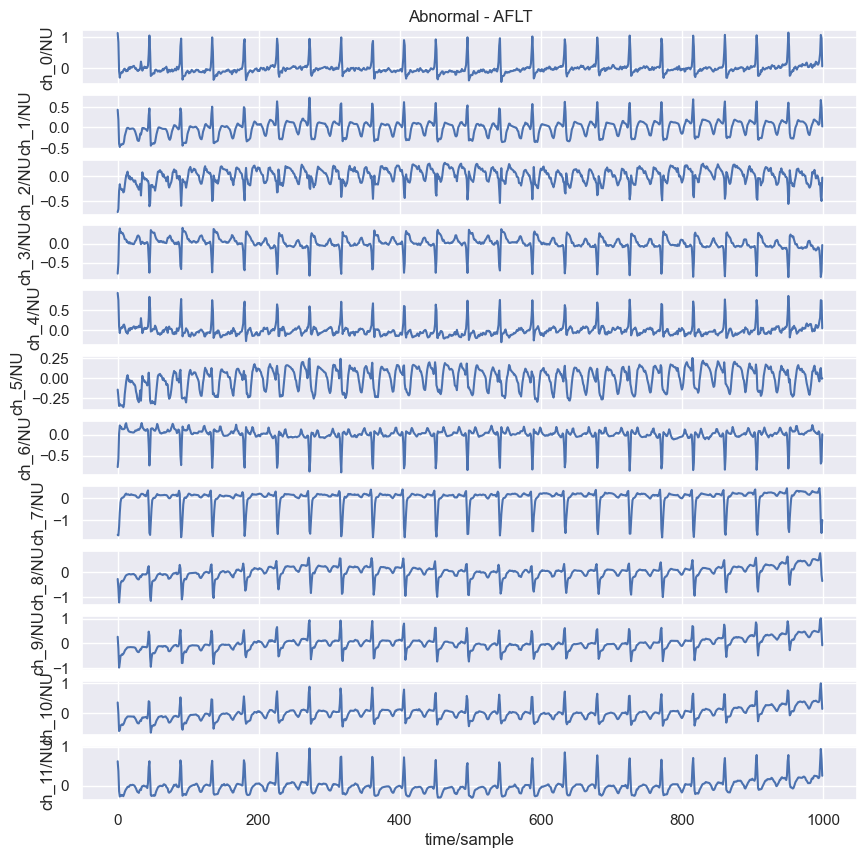

In [10]:
abnormal_sample = dataset_metadata[dataset_metadata["target"] == 1].sample(
    random_state=123)

wfdb.plot_items(
    np.squeeze(ecgs[abnormal_sample.index]),
    fs=fs,
    title="Abnormal" + " - " + abnormal_sample["max_likelihood"].item(),
    figsize=(10, 10),
)